## Import Libraries and Load Dataset

In [1]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

import warnings

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import scipy.stats as stats

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine


import shutil
import re
import string
import spacy
import os
import wget

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
import gensim.downloader as api
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from gensim.models.doc2vec import Doc2Vec

from sentence_transformers import SentenceTransformer

print('_________________All Libraries Have Been Installed.__________________')

C:\Users\The Lion\anaconda3\envs\potential_talents\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


_________________All Libraries Have Been Installed.__________________


In [2]:
dataset = pd.read_csv('../data/raw/potential-talents - Aspiring human resources - seeking human resources.csv')

In [3]:
dataset.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [4]:
dataset.shape

(104, 5)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [6]:
#some basic stats for categorical columns
dataset.describe(include=object)

,job_title,location,connection
count,104,104,104
unique,52,41,33
top,2019 C.T. Bauer College of Business Graduate (...,Kanada,500+
freq,7,12,44


# Analysis

- Dropping id column as we don't need it.

- job_title- This column contains all job titles.

- location- This column contains location of all candidates.

- connection- This column contains the number of connections each candidate has.

- fit- This column is empty and fit score after calculating will be placed in this column.

In [7]:
#droping Id column as we don't need it.
dataset = dataset.drop(['id'], axis=1)
dataset.shape

(104, 4)

### Now we will check for any null values or dubplicated rows.

In [8]:
#checking for null values
dataset.isnull().sum()

job_title       0
location        0
connection      0
fit           104
dtype: int64

In [9]:
#Checking for dublicate values
dataset.duplicated().sum()

51

In [10]:
dataset.shape

(104, 4)

In [11]:
dataset

,job_title,location,connection,fit
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
...,...,...,...,...
99,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN
100,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
101,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
102,Always set them up for Success,Greater Los Angeles Area,500+,NaN


In [12]:
#removing duplicate rows
dataset = dataset.drop_duplicates()
dataset.shape

(53, 4)

## Analysis

- There are no null values in columns, except for fit column which is supposed to be empty as fit score will be calculated and placed in this column.
- There are total 51 duplicated rows which are removed.

# Text Preprocessing

In [13]:
def preprocessing_data(data):
    print('============Before Preprocessing=============')
    for index,text in enumerate(data['job_title'][0:5]):
        print('job_title %d:\n'%(index+1),text)
    
    # Loading model
    nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
    stop = stopwords.words('english')
    
    #removing punctuations
    data['job_title'] = data['job_title'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    data['connection'] = data['connection'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    data['connection'] = data['connection'].astype(str).astype(int)
    
    #replacing HR with Human Resources
    data['job_title'] = data['job_title'].apply(lambda x:x.replace('HR', ' Human Resources '))
    
    #removing extra spaces
    data['job_title'] = data['job_title'].apply(lambda x: re.sub(' +',' ',x))
    
    #lowercase the words
    data['job_title'] = data['job_title'].apply(lambda x: x.lower())
    
    #remove numbers
    data['job_title'] = data['job_title'].apply(lambda x: re.sub(r'\d+', '', x))
    
    #remove white spaces
    data['job_title'] = data['job_title'].apply(lambda x: x.strip())
        
    # Lemmatization with stopwords removal
    data['job_title']=data['job_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    #.apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
    
    #after Preprocessing
    print('============After Preprocessing=============')
    for index,text in enumerate(data['job_title'][0:5]):
        print('job_title %d:\n'%(index+1),text)
    
    return data

In [14]:
dataset = preprocessing_data(dataset)

============Before Preprocessing=============
job_title 1:
 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
job_title 2:
 Native English Teacher at EPIK (English Program in Korea)
job_title 3:
 Aspiring Human Resources Professional
job_title 4:
 People Development Coordinator at Ryan
job_title 5:
 Advisory Board Member at Celal Bayar University
============After Preprocessing=============
job_title 1:
 ct bauer college business graduate magna cum laude aspiring human resources professional
job_title 2:
 native english teacher epik english program korea
job_title 3:
 aspiring human resources professional
job_title 4:
 people development coordinator ryan
job_title 5:
 advisory board member celal bayar university


## Analysis
- Above function is used to remove punctuations, white spaces, stopwords, numbers, and to lowercase the words.
- Lemmetaization is used here because of its contextual benefit.
- Connection column has also been changed from object type to int as it will be required for final score calculation.

## Exploratory Data Analysis

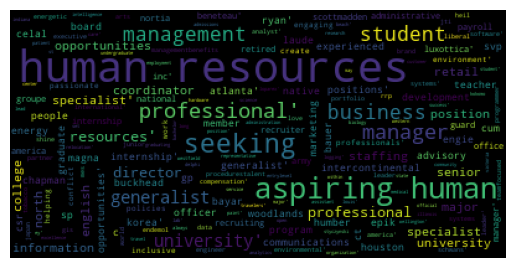

In [15]:
text = dataset['job_title'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Analysis
- above word cloud shows that there are more job titles with asipiring human resources than with seeking human resources.

# Embeddings and Similarity

In [16]:
# These are the search keys to be used for similarity
search_keys = ['aspiring human resources', 'seeking human resources']

## Jaccard Similarity 

In [17]:
#jaccard similarity
def Jaccard_Similarity(doc1, doc2): 
    
    # List the unique words in a document
    words_doc1 = set(doc1.lower().split()) 
    words_doc2 = set(doc2.lower().split())
    
    # Find the intersection of words list of doc1 & doc2
    intersection = words_doc1.intersection(words_doc2)

    # Find the union of words list of doc1 & doc2
    union = words_doc1.union(words_doc2)
        
    # Calculate Jaccard similarity score 
    # using length of intersection set divided by length of union set
    return float(len(intersection)) / len(union)


In [18]:
jaccard_score = []
for job in list(dataset['job_title']):
    score_jac_1 = Jaccard_Similarity(job,search_keys[0])
    score_jac_2 = Jaccard_Similarity(job,search_keys[1])
    jaccard_score.append((score_jac_1+score_jac_2)/2)

dataset['Jaccard Score'] = jaccard_score

In [19]:
dataset.sort_values(by=['Jaccard Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.575000
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.575000
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.575000
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.575000
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.575000
73,human resources professional,Greater Boston Area,16,NaN,0.500000
72,aspiring human resources manager seeking inter...,"Houston, Texas Area",7,NaN,0.500000
9,seeking human resources human resources genera...,Greater Philadelphia Area,500,NaN,0.466667
26,aspiring human resources management student se...,"Houston, Texas Area",500,NaN,0.428571
77,human resources generalist schwans,Amerika Birleşik Devletleri,500,NaN,0.400000


## GloVe Embeddings

### Download and unzip  pre trained GloVe embeddings

In [20]:
#Checking if current directory already has trained model
download_GloVe_embeddings = os.path.isfile('glove.42B.300d.txt.word2vec')
if  download_GloVe_embeddings== False:
    url = 'http://nlp.stanford.edu/data/glove.42B.300d.zip'
    filename = wget.download(url)
    print(filename)
    shutil.unpack_archive('glove.42B.300d.zip')
    glove_filename='glove.42B.300d.txt'
    word2vec_output_file = glove_filename+'.word2vec'
    glove2word2vec(glove_filename, word2vec_output_file)

### Load glove embeddings that were converted word2vec format

In [21]:
glove_model = KeyedVectors.load_word2vec_format('glove.42B.300d.txt.word2vec', binary=False)

### This function will genereate GloVe embeddings for the job_titles and keywords used for comparison.

In [22]:
def get_glove_embeddings(data,glove_model):
    """This function will be used to find the the GloVe Vectors for Job titles.
    
    args:
    
    data (list): list of job titles 
    
    glove_model (dictionary): GloVe pre trained embeddings
    
    return:
    
    glove_vectors (list) : list of GloVe Vectors for job titles
    
    """
    
    glove_vectors = []
    token_vector = []
    #This loop will go through every job title, tokenize it,
    #and then find if the words are in glove model
    #and then find embeddings for those words 
    for title in data:
        token_vector = []
        sentence_tokens = word_tokenize(title)
        words = [word for word in sentence_tokens if word in glove_model.index_to_key]
        for token in sentence_tokens:
            if token in words:
                vector = glove_model[token]
                token_vector.append(vector)
        glove_vectors.append(token_vector)
    
    return glove_vectors
    

### Now We can get GloVe embedding vectors for our text data.

In [23]:
glove_vectors = get_glove_embeddings(list(dataset['job_title']),glove_model)
search_vectors = get_glove_embeddings(search_keys,glove_model)

#### At this step we calculate cosine similarity for every job title with respect to both search vectors.
#### Cosine similatry will return a matrix with similairty score with respect to each word, which will be flatten to generate an average final socre.

### Cosine similarity with GloVe Embeddings

In [24]:
# Cosine similarity
gloveScore = []
for i in range(len(glove_vectors)) :
    score1 = cosine_similarity(glove_vectors[i], search_vectors[0])
    score2 = cosine_similarity(glove_vectors[i], search_vectors[1])
    gloveScore.append((np.mean(score1.flatten())+np.mean(score2.flatten())/2))
    #print(gloveScore)
dataset['GloVe Score'] = gloveScore

In [25]:
dataset.sort_values(by=['GloVe Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score,GloVe Score
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.575000,0.858340
73,human resources professional,Greater Boston Area,16,NaN,0.500000,0.851835
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.575000,0.810357
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.575000,0.804556
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.575000,0.804556
87,human resources management major,"Milpitas, California",18,NaN,0.400000,0.792651
9,seeking human resources human resources genera...,Greater Philadelphia Area,500,NaN,0.466667,0.786501
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.575000,0.781364
72,aspiring human resources manager seeking inter...,"Houston, Texas Area",7,NaN,0.500000,0.776471
7,human resources senior specialist,San Francisco Bay Area,500,NaN,0.400000,0.771921


### Doc2Vec embeddings

This code block will train a new Doc2Vec model on text8 dataset provided by gensim

In [26]:
#Checking if current directory already has trained model
train_doc2vec_model = os.path.isfile('my_doc2vec_model')
if  train_doc2vec_model == False:
    dataset = api.load("text8")
    data = [d for d in dataset]
    def tagged_document(list_of_list_of_words):
        for i, list_of_words in enumerate(list_of_list_of_words):
            yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
    
    data_training = list(tagged_document(data))
    Doc2Vec_model  = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=3, epochs=150)
    Doc2Vec_model.build_vocab(data_training)

    Doc2Vec_model.train(data_training, total_examples=Doc2Vec_model.corpus_count, epochs=Doc2Vec_model.epochs)
    fname = "my_doc2vec_model"
    Doc2Vec_model.save(fname)

Load the previouslty trained gensim model

In [27]:
doc2vec = Doc2Vec.load('my_doc2vec_model')
vector = doc2vec.infer_vector(['seeking', 'human', 'resources'])
print(f'Length of vector taken from Doc2Vec model for each sentence or paragraph is: {len(vector)}')
print(f'vocabulary size or number of words in Doc2vec trained model on text8 data is : {len(doc2vec.wv.key_to_index)}')

Length of vector taken from Doc2Vec model for each sentence or paragraph is: 300
vocabulary size or number of words in Doc2vec trained model on text8 data is : 100038


This function will provide embeddings for each job title as a single vector

In [28]:
# Get Doc2Vec embeddings
def get_doc2vec_embeddings(data, doc2vec_model):
    """This function will be used to find the the doc2vec Vectors for Job titles.
    
    args:
    
    data (list): list of job titles 
    
    doc2vec_model (dictionary): Doc2Vec pre trained embeddings 
    
    return:
    
    doc2vec_vectors (list) : list of doc2vec_vectors for job titles
    
    """
    doc2vec_vectors=[]
    for title in data:
        sentence_tokens = word_tokenize(title)
        tokens = list(filter(lambda x: x in doc2vec_model.wv.index_to_key, sentence_tokens))
        doc2vec_vectors.append(doc2vec_model.infer_vector(tokens))
    
    return doc2vec_vectors

Getting embeddings for job titles and search phrases

In [29]:
doc2vec_vectors = get_doc2vec_embeddings(list(dataset['job_title']), doc2vec)
doc2vec_search_vectors = get_doc2vec_embeddings(search_keys,doc2vec)

In [30]:
# Cosine similarity
doc2vecScore = []
for i in range(len(doc2vec_vectors)) :
    score1 = cosine_similarity(np.reshape(doc2vec_vectors[i],(1,-1)), np.reshape(doc2vec_search_vectors[0],(1,-1)))
    score2 = cosine_similarity(np.reshape(doc2vec_vectors[i],(1,-1)), np.reshape(doc2vec_search_vectors[1],(1,-1)))
    doc2vecScore.append(np.mean(np.concatenate((score1,score2)).flatten()))
    
dataset['Doc2Vec Score'] = doc2vecScore

In [31]:
dataset.sort_values(by=['Doc2Vec Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score,GloVe Score,Doc2Vec Score
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.575000,0.858340,0.820250
67,human resources specialist luxottica,Greater New York City Area,500,NaN,0.400000,0.601182,0.784931
89,undergraduate research assistant styczynski lab,Greater Atlanta Area,155,NaN,0.000000,0.421751,0.736283
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.575000,0.810357,0.709456
10,student chapman university,"Lake Forest, California",2,NaN,0.000000,0.518610,0.709374
93,seeking human resources opportunities open tra...,Amerika Birleşik Devletleri,415,NaN,0.339286,0.704278,0.706791
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.575000,0.804556,0.690654
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.575000,0.804556,0.684936
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.575000,0.781364,0.679897
97,student,"Houston, Texas Area",4,NaN,0.000000,0.682137,0.675684


## Bert Embeddings

In [32]:
# Build BERT_base model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
bert_vectors = bert_model.encode(list(dataset['job_title']))
bert_search_vectors = bert_model.encode(search_keys)

In [33]:
# Cosine similarity
BertScore = []
for i in range(len(doc2vec_vectors)) :
    score1 = cosine_similarity(np.reshape(bert_vectors[i],(1,-1)), np.reshape(bert_search_vectors[0],(1,-1)))
    score2 = cosine_similarity(np.reshape(bert_vectors[i],(1,-1)), np.reshape(bert_search_vectors[1],(1,-1)))
    BertScore.append(np.mean(np.concatenate((score1,score2)).flatten()))
    
dataset['BERT Score'] = BertScore

In [34]:
dataset.sort_values(by=['BERT Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score,GloVe Score,Doc2Vec Score,BERT Score
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.575000,0.810357,0.709456,0.905945
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.575000,0.858340,0.820250,0.901761
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.575000,0.781364,0.679897,0.829190
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.575000,0.804556,0.690654,0.818317
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.575000,0.804556,0.684936,0.818317
9,seeking human resources human resources genera...,Greater Philadelphia Area,500,NaN,0.466667,0.786501,0.541695,0.812103
73,human resources professional,Greater Boston Area,16,NaN,0.500000,0.851835,0.671052,0.788866
81,aspiring human resources professional energeti...,"Austin, Texas Area",174,NaN,0.339286,0.710052,0.498389,0.739012
3,people development coordinator ryan,"Denton, Texas",500,NaN,0.000000,0.610181,0.255723,0.737968
67,human resources specialist luxottica,Greater New York City Area,500,NaN,0.400000,0.601182,0.784931,0.731313


### Add connection column to break the tie
#### Various methods and embeddings types have been used to calculate Similarity scores and so far Bert has out performed them  all. At this stage the column 'connection' which contains number of connection each candidate has will be utilized and incorporated into all scores taken so far to break the tie between two candidates, so the candidate with more connections should be prioritized.

In [35]:
def update_fit_score(score,connection):
    fit_score = score - (1/(connection+10))
    return fit_score

def add_connection_to_score(data):
    data['Jaccard Score'] = data.apply(lambda x: update_fit_score(x['Jaccard Score'],x['connection']),axis=1)
    data['GloVe Score'] = data.apply(lambda x: update_fit_score(x['GloVe Score'],x['connection']),axis=1)
    data['Doc2Vec Score'] = data.apply(lambda x: update_fit_score(x['Doc2Vec Score'],x['connection']),axis=1)
    data['BERT Score'] = data.apply(lambda x: update_fit_score(x['BERT Score'],x['connection']),axis=1)
    return data

In [36]:
final_dataset = add_connection_to_score(dataset)

In [37]:
final_dataset.sort_values(by=['BERT Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score,GloVe Score,Doc2Vec Score,BERT Score
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.572500,0.855840,0.817750,0.899261
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.557759,0.793116,0.692214,0.888704
9,seeking human resources human resources genera...,Greater Philadelphia Area,500,NaN,0.464706,0.784541,0.539734,0.810142
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.562654,0.792210,0.678308,0.805972
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.556481,0.786037,0.666417,0.799799
73,human resources professional,Greater Boston Area,16,NaN,0.461538,0.813374,0.632590,0.750405
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.484091,0.690455,0.588988,0.738281
3,people development coordinator ryan,"Denton, Texas",500,NaN,-0.001961,0.608221,0.253763,0.736008
81,aspiring human resources professional energeti...,"Austin, Texas Area",174,NaN,0.333851,0.704617,0.492954,0.733577
67,human resources specialist luxottica,Greater New York City Area,500,NaN,0.398039,0.599221,0.782971,0.729353


## Analysis
- At first step jaccard similairty was used as a base line model.
- For the rest of the embedding models cosine similarity was used.
- To understand the impact of static vs contextual embeddings GloVe, Doc2Vec, and BERT are used.
- GloVe performed well compare to Doc2Vec Model, however Doc2Vec model can be further imporved by training on a large dataset  that is similar to the problem at hand.
- Bert outperformed all the models, which shows contextual embeddings should be used for this problem 
Similarity based on Bert Vectors outperform every other model.

## ReRank Candidates

- Re rank using the job title starred as keyword and finding its cosine similarity to all the other job titles.
- For this task Bert Embeddings vectors will be used

In [38]:
index = final_dataset.index
print('Candidate Ids list')
for i in index:
    print(i,end=' ')

Candidate Ids list
0 1 2 3 4 5 6 7 9 10 11 12 26 27 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 

In [39]:
starred = input('Enter id of the candidate you would like to starr: ')

Enter id of the candidate you would like to starr: 27


In [40]:
# Build BERT_base model and get Bert vectors
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
rerank_key = final_dataset[final_dataset.index.isin([int(starred)])]['job_title'].tolist()
bert_vectors_rerank = bert_model.encode(list(final_dataset['job_title']))
rerank_vectors = bert_model.encode(rerank_key)

In [41]:
# Cosine similarity
RerankScore = []
for i in range(len(bert_vectors_rerank)) :
    re_rank_score = cosine_similarity(np.reshape(bert_vectors_rerank[i],(1,-1)), np.reshape(rerank_vectors[0],(1,-1)))
    RerankScore.append(re_rank_score[0][0])
    
final_dataset['Rerank Score'] = RerankScore

In [42]:
final_dataset.sort_values(by=['Rerank Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score,GloVe Score,Doc2Vec Score,BERT Score,Rerank Score
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.572500,0.855840,0.817750,0.899261,1.000000
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.557759,0.793116,0.692214,0.888704,0.975387
9,seeking human resources human resources genera...,Greater Philadelphia Area,500,NaN,0.464706,0.784541,0.539734,0.810142,0.886123
73,human resources professional,Greater Boston Area,16,NaN,0.461538,0.813374,0.632590,0.750405,0.803634
93,seeking human resources opportunities open tra...,Amerika Birleşik Devletleri,415,NaN,0.336933,0.701925,0.704438,0.721258,0.797711
3,people development coordinator ryan,"Denton, Texas",500,NaN,-0.001961,0.608221,0.253763,0.736008,0.747332
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.484091,0.690455,0.588988,0.738281,0.741560
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.556481,0.786037,0.666417,0.799799,0.739644
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.562654,0.792210,0.678308,0.805972,0.739644
88,director human resources ey,Greater Atlanta Area,349,NaN,0.397214,0.631710,0.586099,0.716098,0.736389
